In [2]:
import pandas as pd
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import ast

warnings.filterwarnings("ignore")

In [3]:
# Use this chunk to generate the dataset if not already created
# df = pd.DataFrame()
# files = os.listdir("./data/patients_new")
# for file in files:
    # patient = pd.read_json(os.path.join("./data/patients_new/", file))
    # df = pd.concat([df, patient], ignore_index=True)
# df.reset_index(drop=True)
# df.to_csv("./collated_dataset.csv", index=False)

df = pd.read_csv("./collated_dataset.csv")

In [4]:
# Normalize admit and discharge times, and calculate duration of stay
df = df.sort_values(by=["admittime"]).reset_index(drop=True)
df['admittime_wy'] = df['admittime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
df['dischtime_wy'] = df['dischtime'].apply(lambda x: pd.to_datetime(x).replace(year=2024))
df['dischtime_wy'] = df.apply(lambda row: pd.to_datetime(row['dischtime_wy']).replace(year=2025) if row['dischtime_wy'].month < row['admittime_wy'].month else row['dischtime_wy'], axis=1)
df["duration_of_stay"] = pd.to_datetime(df["dischtime_wy"]) - pd.to_datetime(df["admittime_wy"])
df

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,pharmacy,poe,prescriptions,procedures_icd,services,transfers,icustays,admittime_wy,dischtime_wy,duration_of_stay
0,10001725,25563031,2110-04-11 15:08:00,2110-04-14 15:00:00,NaN,EW EMER.,P35SU0,PACU,HOME,Other,...,"[{'subject_id': 10001725, 'hadm_id': 25563031,...","[{'poe_id': '10001725-48', 'poe_seq': 48, 'sub...","[{'subject_id': 10001725, 'hadm_id': 25563031,...","[{'subject_id': 10001725, 'hadm_id': 25563031,...","[{'subject_id': 10001725, 'hadm_id': 25563031,...","[{'subject_id': 10001725, 'hadm_id': 25563031....","[{'subject_id': 10001725, 'hadm_id': 25563031,...",2024-04-11 15:08:00,2024-04-14 15:00:00,2 days 23:52:00
1,10008454,20291550,2110-11-30 06:31:00,2110-12-10 15:53:00,NaN,EW EMER.,P77BSD,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,"[{'subject_id': 10008454, 'hadm_id': 20291550,...","[{'poe_id': '10008454-137', 'poe_seq': 137, 's...","[{'subject_id': 10008454, 'hadm_id': 20291550,...","[{'subject_id': 10008454, 'hadm_id': 20291550,...","[{'subject_id': 10008454, 'hadm_id': 20291550,...","[{'subject_id': 10008454, 'hadm_id': 20291550....","[{'subject_id': 10008454, 'hadm_id': 20291550,...",2024-11-30 06:31:00,2024-12-10 15:53:00,10 days 09:22:00
2,10004422,21255400,2111-01-15 14:55:00,2111-01-25 15:00:00,NaN,EW EMER.,P1037P,PROCEDURE SITE,HOME HEALTH CARE,Medicare,...,"[{'subject_id': 10004422, 'hadm_id': 21255400,...","[{'poe_id': '10004422-100', 'poe_seq': 100, 's...","[{'subject_id': 10004422, 'hadm_id': 21255400,...","[{'subject_id': 10004422, 'hadm_id': 21255400,...","[{'subject_id': 10004422, 'hadm_id': 21255400,...","[{'subject_id': 10004422, 'hadm_id': 21255400....","[{'subject_id': 10004422, 'hadm_id': 21255400,...",2024-01-15 14:55:00,2024-01-25 15:00:00,10 days 00:05:00
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,"[{'subject_id': 10006053, 'hadm_id': 22942076,...","[{'poe_id': '10006053-41', 'poe_seq': 41, 'sub...","[{'subject_id': 10006053, 'hadm_id': 22942076,...","[{'subject_id': 10006053, 'hadm_id': 22942076,...","[{'subject_id': 10006053, 'hadm_id': 22942076,...","[{'subject_id': 10006053, 'hadm_id': 22942076....","[{'subject_id': 10006053, 'hadm_id': 22942076,...",2024-11-13 23:39:00,2024-11-15 17:20:00,1 days 17:41:00
4,10035631,29462354,2112-09-17 19:13:00,2112-10-17 01:41:00,NaN,DIRECT EMER.,P45GUA,PHYSICIAN REFERRAL,HOME,Other,...,"[{'subject_id': 10035631, 'hadm_id': 29462354,...","[{'poe_id': '10035631-269', 'poe_seq': 269, 's...","[{'subject_id': 10035631, 'hadm_id': 29462354,...","[{'subject_id': 10035631, 'hadm_id': 29462354,...","[{'subject_id': 10035631, 'hadm_id': 29462354,...","[{'subject_id': 10035631, 'hadm_id': 29462354....",[],2024-09-17 19:13:00,2024-10-17 01:41:00,29 days 06:28:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,10002930,20846853,2201-02-12 16:58:00,2201-02-13 11:11:00,NaN,EU OBSERVATION,P2358X,PHYSICIAN REFERRAL,NaN,Medicare,...,[],"[{'poe_id': '10002930-417', 'poe_seq': 417, 's...",[],[],"[{'subject_id': 10002930, 'hadm_id': 20846853,...","[{'subject_id': 10002930, 'hadm_id': 20846853....",[],2024-02-12 16:58:00,2024-02-13 11:11:00,0 days 18:13:00
271,10002930,20282368,2201-03-23 19:15:00,2201-03-26 14:24:00,NaN,EU OBSERVATION,P850UN,PHYSICIAN REFERRAL,NaN,Medicare,...,[],"[{'poe_id': '10002930-456', 'poe_seq': 456, 's...",[],[],"[{'subject_id': 10002930, 'hadm_id': 20282368,...","[{'subject_id': 10002930, 'hadm_id': 20282368....",[],2024-03-23 19:15:00,2024-03-26 14:24:00,2 days 19:09:00
272,10026255,22059910,2201-07-07 18:15:00,2201-07-13 23:27:00,2201-07-13 23:27:00,EW EMER.,P48KFD,EMERGENCY ROOM,DIED,Other,...,"[{'subject_id': 10026255, 'hadm_id': 22059910,...","[{'poe_id': '10026255-427', 'poe_seq': 427, 's...","[{'subject_id': 10026255, 'hadm_id': 22059910,...",[],"[{'subject_id': 10026255, 

In [5]:
# Take the sub-datasets (patients, hosp, poe, etc.), flatten them and append them to the main dataframe
def normalize_jsons(column, dropper, sorter):
    data = []
    for datum in column:
        json_df = pd.json_normalize(ast.literal_eval(datum)[0])
        data.append(json_df)
    column_df = pd.concat(data, ignore_index=True).drop_duplicates(subset=dropper).sort_values(by=sorter).reset_index(drop=True)
    return column_df

In [6]:
df = pd.merge(df, normalize_jsons(df["patients"], ["subject_id"], ["anchor_year", "subject_id"]), how='left', on="subject_id", suffixes=("", ""))
df

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,...,transfers,icustays,admittime_wy,dischtime_wy,duration_of_stay,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10001725,25563031,2110-04-11 15:08:00,2110-04-14 15:00:00,NaN,EW EMER.,P35SU0,PACU,HOME,Other,...,"[{'subject_id': 10001725, 'hadm_id': 25563031....","[{'subject_id': 10001725, 'hadm_id': 25563031,...",2024-04-11 15:08:00,2024-04-14 15:00:00,2 days 23:52:00,F,46,2110,2011 - 2013,
1,10008454,20291550,2110-11-30 06:31:00,2110-12-10 15:53:00,NaN,EW EMER.,P77BSD,EMERGENCY ROOM,HOME HEALTH CARE,Other,...,"[{'subject_id': 10008454, 'hadm_id': 20291550....","[{'subject_id': 10008454, 'hadm_id': 20291550,...",2024-11-30 06:31:00,2024-12-10 15:53:00,10 days 09:22:00,F,26,2110,2011 - 2013,
2,10004422,21255400,2111-01-15 14:55:00,2111-01-25 15:00:00,NaN,EW EMER.,P1037P,PROCEDURE SITE,HOME HEALTH CARE,Medicare,...,"[{'subject_id': 10004422, 'hadm_id': 21255400....","[{'subject_id': 10004422, 'hadm_id': 21255400,...",2024-01-15 14:55:00,2024-01-25 15:00:00,10 days 00:05:00,M,78,2111,2011 - 2013,
3,10006053,22942076,2111-11-13 23:39:00,2111-11-15 17:20:00,2111-11-15 17:20:00,URGENT,P38TI6,TRANSFER FROM HOSPITAL,DIED,Medicaid,...,"[{'subject_id': 10006053, 'hadm_id': 22942076....","[{'subject_id': 10006053, 'hadm_id': 22942076,...",2024-11-13 23:39:00,2024-11-15 17:20:00,1 days 17:41:00,M,52,2111,2014 - 2016,2111-11-15
4,10035631,29462354,2112-09-17 19:13:00,2112-10-17 01:41:00,NaN,DIRECT EMER.,P45GUA,PHYSICIAN REFERRAL,HOME,Other,...,"[{'subject_id': 10035631, 'hadm_id': 29462354....",[],2024-09-17 19:13:00,2024-10-17 01:41:00,29 days 06:28:00,M,63,2112,2011 - 2013,2116-03-12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
270,10002930,20846853,2201-02-12 16:58:00,2201-02-13 11:11:00,NaN,EU OBSERVATION,P2358X,PHYSICIAN REFERRAL,NaN,Medicare,...,"[{'subject_id': 10002930, 'hadm_id': 20846853....",[],2024-02-12 16:58:00,2024-02-13 11:11:00,0 days 18:13:00,F,48,2193,2011 - 2013,2201-12-24
271,10002930,20282368,2201-03-23 19:15:00,2201-03-26 14:24:00,NaN,EU OBSERVATION,P850UN,PHYSICIAN REFERRAL,NaN,Medicare,...,"[{'subject_id': 10002930, 'hadm_id': 20282368....",[],2024-03-23 19:15:00,2024-03-26 14:24:00,2 days 19:09:00,F,48,2193,2011 - 2013,2201-12-24
272,10026255,22059910,2201-07-07 18:15:00,2201-07-13 23:27:00,2201-07-13 23:27:00,EW EMER.,P48KFD,EMERGENCY ROOM,DIED,Other,...,"[{'subject_id': 10026255, 'hadm_id': 22059910....","[{'subject_id': 10026255, 'hadm_id': 22059910,...",2024-07-07 18:15:00,2024-07-13 23:27:00,6 days 05:12:00,M,66,2200,2011 - 2013,2201-07-13
273,10027602,28166872,2201-10-30 12:05:00,2201-11-20 14:45:00,NaN,EW EMER.,P47SIK,EMERGENCY ROOM,REHAB,Other,...,"[{'subject_id': 10027602, 'hadm_id': 28166872....","[{'subject_id': 10027602, 'hadm_id': 28166872,...",2024-10-30 12:05:00,2024-11-20 14:45:00,21 days 02:40:00,F,71,2201,2014 - 2016,


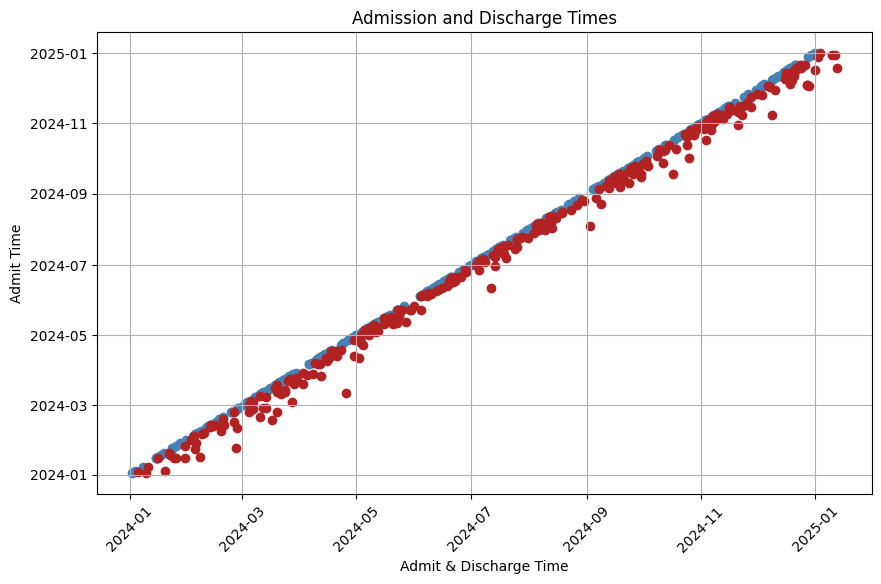

In [7]:
# Visualize admit and discharge time deltas (duration of stay) for all patients. Duration of stay is a good indicator of the value of care derived by class of patient.
plt.figure(figsize=(10, 6))
plt.scatter(pd.to_datetime(df['admittime_wy']), df['admittime_wy'], color="steelblue")
plt.scatter(pd.to_datetime(df['dischtime_wy']), df['admittime_wy'], color="firebrick")

plt.xlabel('Admit & Discharge Time')
plt.ylabel('Admit Time')
plt.title('Admission and Discharge Times')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [8]:
# We'll explore duration of stay based on four demographic indicators: class, race, gender and age.
# Race and gender are provided in the data. We'll use insurance (Medicaid or not) as a proxy for class. Age has been obfuscated in the dataset to "anchor age", which is approximately accurate.

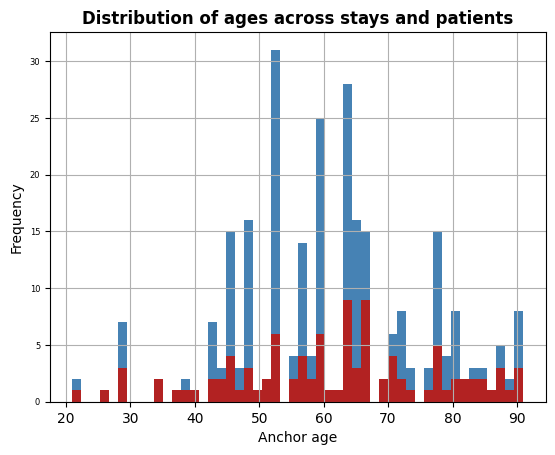

In [9]:
# We'll look at the distribution of ages to make sure it's about correct.
# Note that the spike at age 91 is because everyone above 89 is assigned 91 for privacy.
bins = len(df["anchor_age"].value_counts())
ax = df["anchor_age"].hist(bins=bins, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = df.drop_duplicates(subset="subject_id")["anchor_age"].hist(bins=bins, xlabelsize=10, ylabelsize=6, color="firebrick")

ax.set_title('Distribution of ages across stays and patients', weight='bold')
ax.set_xlabel('Anchor age')
ax.set_ylabel('Frequency')
plt.show()

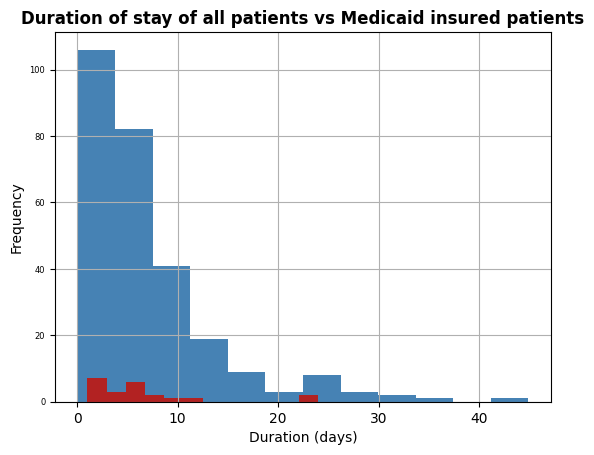

Non-Medicaid-insured patients: 6 days 22:22:08.537549407
Medicaid-insured patients: 6 days 10:52:10.909090909


In [10]:
# Medicaid patients are discharged, on average, slightly quicker than other patients
medicaid_df = df[df["insurance"] == "Medicaid"]
main_df = df[~df.index.isin(medicaid_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (medicaid_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of all patients vs Medicaid insured patients', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"Non-Medicaid-insured patients: {main_df['duration_of_stay'].mean()}")
print(f"Medicaid-insured patients: {medicaid_df['duration_of_stay'].mean()}")

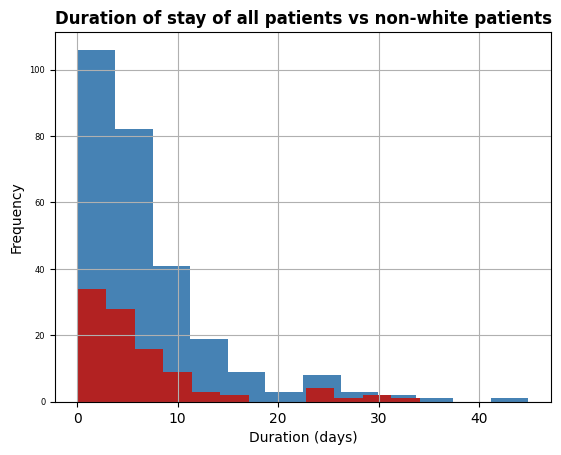

White patients: 7 days 01:40:22.628571428
Non-white patients: 6 days 14:03:26.400000


In [11]:
# Non-white patients are discharged, on average, significantly quicker than white patients
non_white_df = df[~df["race"].str.contains("WHITE")]
main_df = df[~df.index.isin(non_white_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (non_white_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of all patients vs non-white patients', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"White patients: {main_df['duration_of_stay'].mean()}")
print(f"Non-white patients: {non_white_df['duration_of_stay'].mean()}")

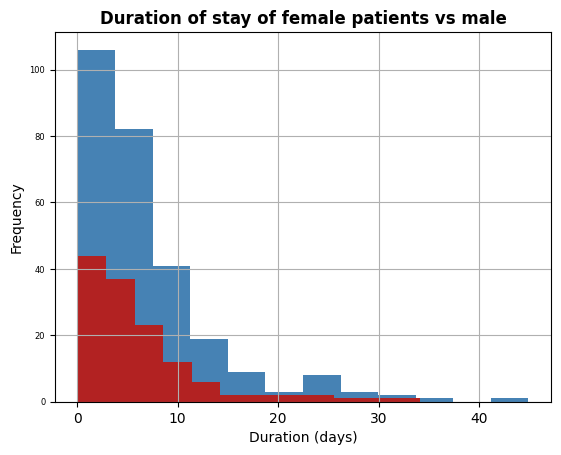

Male patients: 7 days 11:27:38.028169014
Female patients: 6 days 06:29:22.105263157


In [12]:
# Female patients are discharged much quicker than male patients
female_df = df[df["gender"] == "F"]
main_df = df[~df.index.isin(female_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (female_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of female patients vs male', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"Male patients: {main_df['duration_of_stay'].mean()}")
print(f"Female patients: {female_df['duration_of_stay'].mean()}")

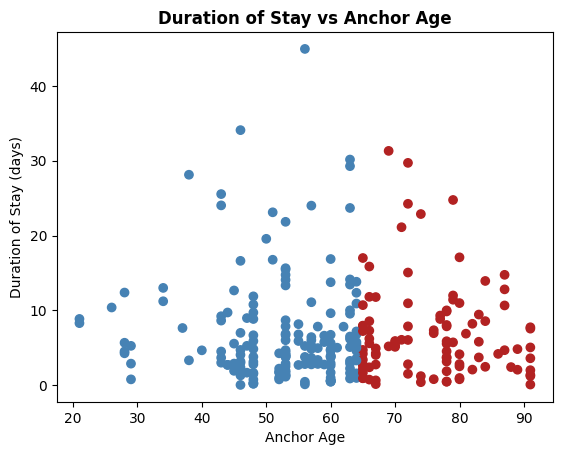

Young patients: 6 days 22:25:47.368421052
Old patients: 6 days 19:50:11.538461538


In [26]:
# There doesn't appear to be a significant trend of duration with age past 45 or so
old_df = df[df["anchor_age"] >= 65]
main_df = df[~df.index.isin(old_df.index)]

plt.scatter(df["anchor_age"], (df["duration_of_stay"].dt.total_seconds() / 86400), c=df["anchor_age"].apply(lambda x: "firebrick" if x >= 65 else "steelblue"))
plt.xlabel('Anchor Age')
plt.ylabel('Duration of Stay (days)')
plt.title('Duration of Stay vs Anchor Age', weight='bold')
plt.show()

print(f"Young patients: {main_df['duration_of_stay'].mean()}")
print(f"Old patients: {old_df['duration_of_stay'].mean()}")

In [14]:
# We can also look at the interactions of protected attributes to see if a trend emerges. For example, are black women treated worse than other patients?

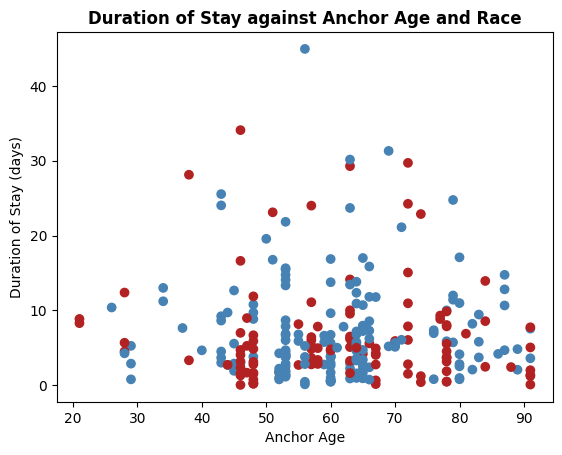

In [25]:
# Age and race don't reveal a meaningful pattern
plt.scatter(df["anchor_age"], (df["duration_of_stay"].dt.total_seconds() / 86400), c=df["race"].apply(lambda x: "firebrick" if x != "WHITE" else "steelblue"))
plt.xlabel('Anchor Age')
plt.ylabel('Duration of Stay (days)')
plt.title('Duration of Stay against Anchor Age and Race', weight='bold')
plt.show()

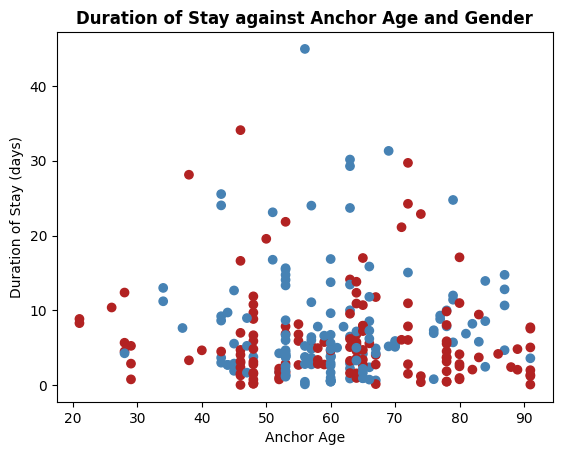

In [24]:
# Age and gender reveal that
plt.scatter(df["anchor_age"], (df["duration_of_stay"].dt.total_seconds() / 86400), c=df["gender"].apply(lambda x: "firebrick" if x == "F" else "steelblue"))
plt.xlabel('Anchor Age')
plt.ylabel('Duration of Stay (days)')
plt.title('Duration of Stay against Anchor Age and Gender', weight='bold')
plt.show()

In [16]:
# We can now look at variation in stay duration based on other information, such as admission circumstances.

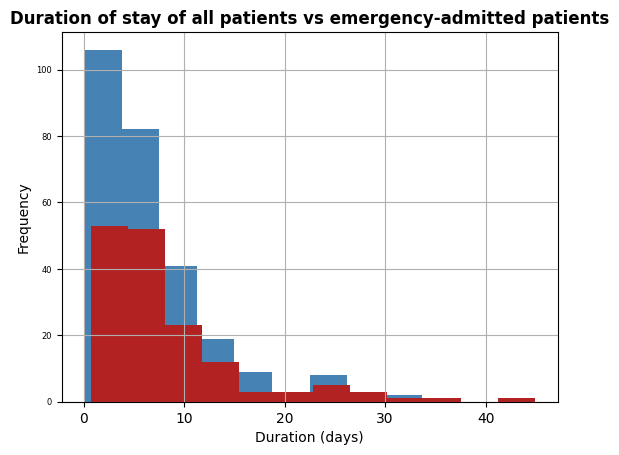

Otherwise-admitted patients: 5 days 06:00:32.542372881
Emergency-admitted patients: 8 days 03:05:30.955414012


In [17]:
# Patients admitted under emergency conditions are in hospital for significantly longer than other patients
emergency_df = df[(df["admission_type"].str.contains("EMER")) | (df["admission_type"].str.contains("URGENT"))]
main_df = df[~df.index.isin(emergency_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (emergency_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of all patients vs emergency-admitted patients', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"Otherwise-admitted patients: {main_df['duration_of_stay'].mean()}")
print(f"Emergency-admitted patients: {emergency_df['duration_of_stay'].mean()}")

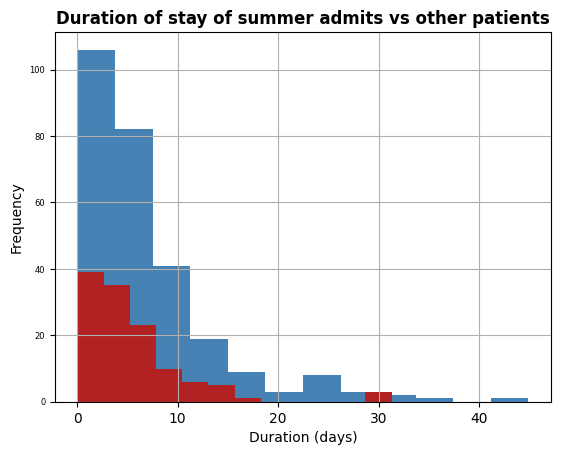

Patients admitted outside summer: 8 days 00:13:53.333333333
Patients admitted during summer: 5 days 11:51:40.819672131


In [18]:
# There is seasonality to stay duration: patients admitted in the summer months are discharged much quicker
summer_df = df[(df["admittime_wy"].dt.month >= 5) & (df['admittime_wy'].dt.month <= 9)]
main_df = df[~df.index.isin(summer_df.index)]

ax = (df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="steelblue")
ax2 = (summer_df["duration_of_stay"].dt.total_seconds() / 86400).hist(bins=12, xlabelsize=10, ylabelsize=6, color="firebrick")
ax.set_title('Duration of stay of summer admits vs other patients', weight='bold')
ax.set_xlabel('Duration (days)')
ax.set_ylabel('Frequency')
plt.show()

print(f"Patients admitted outside summer: {main_df['duration_of_stay'].mean()}")
print(f"Patients admitted during summer: {summer_df['duration_of_stay'].mean()}")

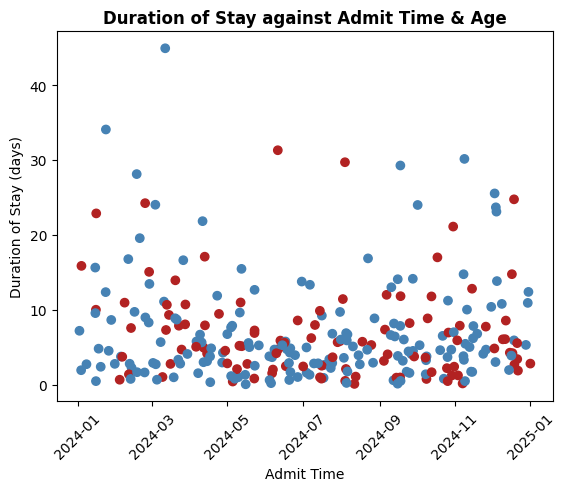

Young winter patients: 7 days 14:16:42.711864406
Old winter patients: 8 days 06:28:42.765957446


In [23]:
# Could age be the reason? While age does account for some of the difference, it doesn't really seem to capture the effect
old_df = df[df["anchor_age"] >= 65]
main_df = df[~df.index.isin(old_df.index)]

plt.scatter(pd.to_datetime(df["admittime_wy"]), (df["duration_of_stay"].dt.total_seconds() / 86400), c=df["anchor_age"].apply(lambda x: "firebrick" if x >= 65 else "steelblue"))
plt.xlabel('Admit Time')
plt.ylabel('Duration of Stay (days)')
plt.title('Duration of Stay against Admit Time & Age', weight='bold')
plt.xticks(rotation=45)
plt.show()

print(f"Young winter patients: {old_df[(old_df['admittime_wy'].dt.month < 5) | (df['admittime_wy'].dt.month > 9)]['duration_of_stay'].mean()}")
print(f"Old winter patients: {main_df[(df['admittime_wy'].dt.month < 5) | (df['admittime_wy'].dt.month > 9)]['duration_of_stay'].mean()}")